# Case Study

In [1]:
import pandas as pd
import numpy as np
import urllib.request
from io import StringIO
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
import statistics
import scipy.stats as stats
import matplotlib.dates as mdates
from scipy.stats import norm

import warnings
pd.options.mode.chained_assignment = None
warnings.filterwarnings("ignore", message="An unsupported index was provided and will be ignored when e.g. forecasting.")

In [2]:
def import_data(link):
  """ Imports the data from a certain url link

    Args:
        link (str): url to the data

    """
  with urllib.request.urlopen(link) as response:
      data = response.read().decode('utf-8')

  data = data.split("\n")
  data_list = []

  for row in data[2:-1]:
      row_list = list(filter(None, row.split(' ')))
      row_list[1] = row_list[1].rstrip('\r')
      data_list.append({'Date': row_list[0], 'Value': row_list[1]})

  df = pd.DataFrame(data_list)
  df['Date'] = pd.to_datetime(df['Date'])
  df['Value'] = df['Value'].astype(float)
  return df

In [3]:
df = import_data('https://hadleyserver.metoffice.gov.uk/hadcet/data/meantemp_daily_totals.txt')

In [4]:
def delete_leap_year(df):
  """ Deletes leap years from the data frame

    Args:
        df (pd.DataFrame): data frame with leap years

    Returns:
        pd.DataFrame: df without the day 02-29

    """
  df['Day'] = df['Date'].dt.day
  df['Month'] = df['Date'].dt.month
  df = df[~((df['Month'] == 2) & (df['Day'] == 29))]
  df.drop(columns=['Day', 'Month'], inplace=True)
  df.reset_index(drop=True, inplace=True)
  return df

In [5]:
df = delete_leap_year(df)
for i in df['Date']:
    if '-02-29' in str(i):
        print(i)

### H matrix

In [6]:
def fill_matrix(df, year, day, w):
    """ Fill the matrix with ones for a specic day in a year given a certain window

    Args:
        df (pd.DataFrame): contains the matrix with zeros and ones
        year (int): the year for for which we want to fill the days with ones
        day (str): the day around we want to fill the days with ones
        w (int): the window indicates how many days we want to fill with ones
    """

    day_ind = df.columns.get_loc(day)

    # Loop throught the window
    for i in range(0, int(w/2)):
        ind_bef = day_ind - i
        ind_aft = day_ind + i

        # Handle if days exceeds year
        if ind_aft >= len(df.columns):
            year_aft = year + 1
            df.loc[year_aft, df.columns[ind_aft - len(df.columns)]] = 1
        # Set to 1 for days in given year
        elif ind_aft < len(df.columns):
          df.loc[year, df.columns[ind_aft]] = 1


        # Handle if days deceeds year
        if ind_bef < 0:
            year_bef = year - 1
            df.loc[year_bef, df.columns[ind_bef + len(df.columns)]] = 1
        # Set to 1 for days in given year
        elif ind_bef >= 0:
          df.loc[year, df.columns[ind_bef]] = 1


In [7]:
def get_matrix(first_year, last_year, day):
    """ Create a matrix containing zeros and ones for a specific block around a
    day within certain years

    Args:
        first_year (str): the first year for which we want to create a window of
        ones
        last_year (str): the last year for which we want to create a window of
        ones
        day (str): the day around we want to fill the days with ones

    Returns:
        pd.DataFrame: df containing zeros and ones for a specific date (note
        that the df contains an extra year before and after the last year)

    """

    # Create a list containing all days of a non-leap year
    days_in_year = pd.date_range(start=f'1/1/{2023}', end=f'12/31/{2023}', freq='D')

    # Make a df with days as columns and years 1979-2021 as rows
    df = pd.DataFrame(0, index=range(first_year-1, last_year+2), columns=[f'{date.day}-{date.month}' for date in days_in_year])

    # Define window
    w = 30

    # Loop through the years and fill matrix with 1 ones around a specific date given a window w
    for year in range(first_year, last_year + 1):
        fill_matrix(df, year, day,w)

    return df

In [8]:
def get_subset_df(df, first_year, last_year):
    """ Create a subset of a dataframe given certain years

    Args:
        first_year (str): the first year included in the subset
        last_year (str): the last year included in the subset
        df (pd.DataFrame): df from which we want the subset

    Returns:
        pd.DataFrame: df containing the subset

    """

    subset = df[(df['Date'] >= str(first_year)) & (df['Date'] < str(last_year+1))]

    chunk_size = 365
    chunks = [subset[i:i+chunk_size] for i in range(0, len(subset), chunk_size)]

    df_subset = pd.DataFrame()

    for year in range(0,(last_year-first_year+1)):
        value_series = chunks[year]['Value'].reset_index(drop=True)
        columns = []

        for day in range(0, 365):
            value_for_day = value_series[day]
            column_series = pd.Series(value_for_day)
            columns.append(column_series)

        df_1_year = pd.concat(columns, axis=1)
        df_subset = pd.concat([df_subset, df_1_year], ignore_index=True)

    days_in_year = pd.date_range(start=f'1/1/{2023}', end=f'12/31/{2023}', freq='D')
    df_subset.columns = [f'{date.day}-{date.month}' for date in days_in_year]
    df_subset.index = range(first_year, last_year+1)
    return df_subset

# Hi Lis!!! Hieronder vind je het nieuwe model 

In [9]:
from scipy.optimize import minimize

In [10]:
def compute_QAR_residuals(params):
    alpha = params[0]
    phi = params[1]
    q = 0.95
    
    y = df_subset.values * h.values
    y_min1 = np.roll(y, shift=(0, 1), axis=(1, 1))
    
    I = np.where(h * (y - alpha - phi * y_min1) < 0, 1, 0)
    
    residuals = h * (y - alpha - phi * y_min1) * (q - I)
    
    return residuals.sum().sum()

In [11]:
first_year = 1980
last_year = 2020

error_list = []
alpha_list = []
phi_list = []

df_subset = get_subset_df(df, first_year-1, last_year+1)

for date in pd.date_range(start='1/1/2023', end='12/31/2023', freq='D'):
    h = get_matrix(first_year, last_year, f'{date.day}-{date.month}')

    result = minimize(compute_QAR_residuals, [2, 0.68]) # Dit is de initiële params guess

    error_list.append(result.fun)
    alpha_list.append(result.x[0])
    phi_list.append(result.x[1])
    
    print(f'Finished computing date: {date.day}-{date.month}', end='\r')

In [12]:
total_error = sum(error_list)
total_error

99228.63450974379

In [15]:
params_df = pd.DataFrame()
params_df['Date'] = pd.date_range(start=f'1/1/{2023}', end=f'12/31/{2023}', freq='D')
params_df['Phi'] = phi_list
params_df['Alpha'] = alpha_list

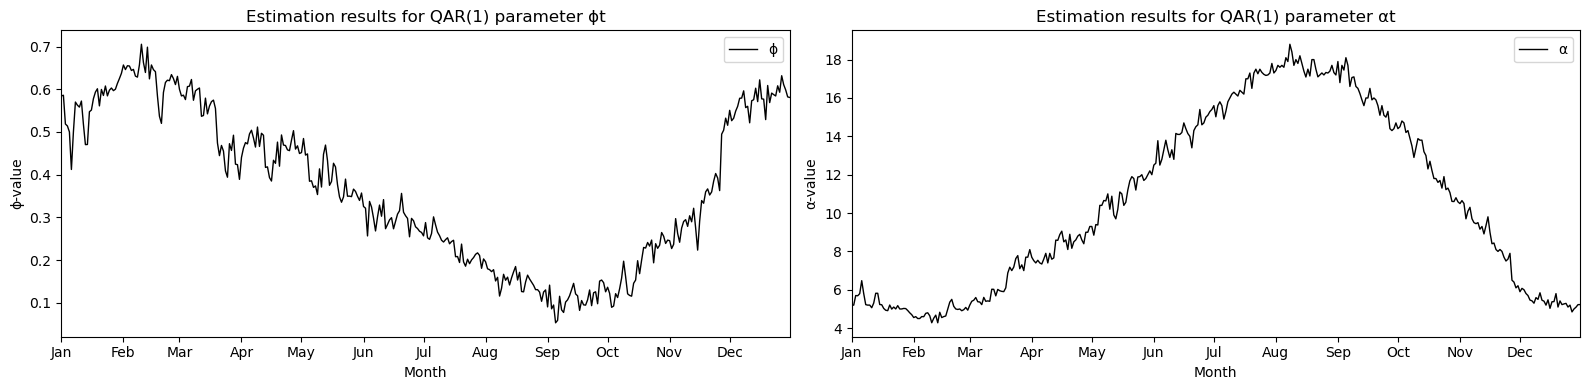

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

ax1.plot(params_df['Date'], params_df['Phi'], label='ϕ', linestyle='-', color='black', linewidth=1)
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax1.xaxis.set_major_locator(mdates.MonthLocator())
ax1.set_xlim(params_df['Date'].min(), params_df['Date'].max())
ax1.set_title('Estimation results for QAR(1) parameter ϕt')
ax1.set_xlabel('Month')
ax1.set_ylabel('ϕ-value')
ax1.legend()

ax2.plot(params_df['Date'], params_df['Alpha'], label='α', linestyle='-', color='black', linewidth=1)
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax2.xaxis.set_major_locator(mdates.MonthLocator())
ax2.set_xlim(params_df['Date'].min(), params_df['Date'].max())
ax2.set_title('Estimation results for QAR(1) parameter αt')
ax2.set_xlabel('Month')
ax2.set_ylabel('α-value')
ax2.legend()

plt.tight_layout()
plt.show()